In [1]:
import warnings
warnings.simplefilter(action='ignore')
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import re, random, pickle, glob, os, difflib
import tensorflow as tf
import numpy as np
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn import metrics
from utils import *
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="" 

In [2]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')


In [3]:
train_root = 'train/'
test_root = 'test/'
model_root = 'models/'
plot_root = 'plots/'
train_sets = ['x10_reads.fa']
test_sets = ['test_easy_1.fa', 'test_easy_2.fa', 'test_intermidate_1.fa', 'test_intermidate_2.fa', 'test_difficult_1.fa', 
             'test_difficult_2.fa', 'test_very_difficult_1.fa', 'test_very_difficult_2.fa']

In [4]:
df = read_fasta(train_root + train_sets[0])
# train_reads_original = np.array(seqs2onehot(np.array(df.seqs)))
# train_reads = np.delete(train_reads_original,3,axis=2)
# train_reads = np.expand_dims(train_reads, -1)
# train_reads.shape

In [6]:
max_feat = 6
tk = Tokenizer(num_words = max_feat, lower = True, oov_token='n', char_level=True)
raw_text_train = df["seqs"].str.lower()
tk.fit_on_texts(raw_text_train)
print(tk.get_config())
X = tk.texts_to_sequences(raw_text_train)
X = np.array(X)

{'num_words': 6, 'filters': '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', 'lower': True, 'split': ' ', 'char_level': True, 'oov_token': 'n', 'document_count': 169538, 'word_counts': '{"g": 5461118, "t": 7257356, "a": 7269394, "c": 5442758, "n": 37, "y": 17, "k": 4, "r": 10, "w": 6}', 'word_docs': '{"g": 169538, "c": 169538, "a": 169538, "t": 169538, "n": 37, "y": 17, "k": 4, "r": 10, "w": 6}', 'index_docs': '{"4": 169538, "5": 169538, "2": 169538, "3": 169538, "6": 37, "7": 17, "10": 4, "8": 10, "9": 6}', 'index_word': '{"6": "n", "2": "a", "3": "t", "4": "g", "5": "c", "7": "y", "8": "r", "9": "w", "10": "k"}', 'word_index': '{"n": 6, "a": 2, "t": 3, "g": 4, "c": 5, "y": 7, "r": 8, "w": 9, "k": 10}'}


In [24]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

In [8]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 150
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = -0.5*tf.reduce_mean(kl_loss)
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    
    def call(self, x):
        x = self.encoder(x)
        return self.decoder(x)

In [16]:
input_size = (150,4,1)
epochs = 150
batch_size = 2048
X[0].shape

(150,)

In [10]:
ckpt_num = 'vanilla_vae'
ckpt_dir = os.path.join(model_root, ckpt_num, '')
if (os.path.isdir(ckpt_dir) == False):
    os.mkdir(os.path.join(ckpt_dir, ''))

In [13]:
K.clear_session()
inp = Input(shape = (150,))
x = Embedding(max_feat, 1)(inp)
x(X[0]).numpy()

TypeError: 'Tensor' object is not callable

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 150)]        0                                            
__________________________________________________________________________________________________
dense_43 (Dense)                (None, 1024)         154624      input_22[0][0]                   
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 16)           16400       dense_43[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 16)           16400       dense_43[0][0]                   
____________________________________________________________________________________________

1/1 [==============================] - 0s 760us/step - loss: 2467.8774 - reconstruction_loss: 2454.8884 - kl_loss: 12.9891
Epoch 45/150
1/1 [==============================] - 0s 753us/step - loss: 2437.7832 - reconstruction_loss: 2425.5635 - kl_loss: 12.2198
Epoch 46/150
1/1 [==============================] - 0s 768us/step - loss: 2466.0410 - reconstruction_loss: 2453.5911 - kl_loss: 12.4499
Epoch 47/150
1/1 [==============================] - 0s 756us/step - loss: 2435.0059 - reconstruction_loss: 2423.2974 - kl_loss: 11.7084
Epoch 48/150
1/1 [==============================] - 0s 773us/step - loss: 2435.1362 - reconstruction_loss: 2423.5933 - kl_loss: 11.5430
Epoch 49/150
1/1 [==============================] - 0s 754us/step - loss: 2465.1062 - reconstruction_loss: 2453.2319 - kl_loss: 11.8742
Epoch 50/150
1/1 [==============================] - 0s 738us/step - loss: 2464.9463 - reconstruction_loss: 2453.0601 - kl_loss: 11.8861
Epoch 51/150
1/1 [==============================] - 0s 755us/

1/1 [==============================] - 0s 846us/step - loss: 2463.1233 - reconstruction_loss: 2453.2236 - kl_loss: 9.8998
Epoch 105/150
1/1 [==============================] - 0s 822us/step - loss: 2432.8455 - reconstruction_loss: 2423.2317 - kl_loss: 9.6138
Epoch 106/150
1/1 [==============================] - 0s 836us/step - loss: 2461.9651 - reconstruction_loss: 2452.2568 - kl_loss: 9.7083
Epoch 107/150
1/1 [==============================] - 0s 850us/step - loss: 2461.8435 - reconstruction_loss: 2452.1594 - kl_loss: 9.6840
Epoch 108/150
1/1 [==============================] - 0s 820us/step - loss: 2461.8840 - reconstruction_loss: 2452.2422 - kl_loss: 9.6419
Epoch 109/150
1/1 [==============================] - 0s 854us/step - loss: 2431.8997 - reconstruction_loss: 2422.6475 - kl_loss: 9.2521
Epoch 110/150
1/1 [==============================] - 0s 835us/step - loss: 2461.4106 - reconstruction_loss: 2452.0979 - kl_loss: 9.3128
Epoch 111/150
1/1 [==============================] - 0s 797us/

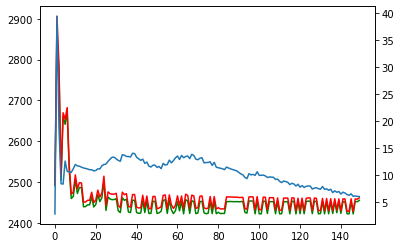

In [27]:
with strategy.scope():
    for width in [256]:
        for f_size in [10]:
            for latent_dim in [16]:
                filter_size = (f_size, 4)
                
                hist_path = os.path.join(model_root, ckpt_num, str(f_size)+'_'+str(latent_dim))
                encoder_inputs = keras.Input(150,)
                x = layers.Dense(width*4, activation="relu")(encoder_inputs)
                z_mean = layers.Dense(latent_dim, name="z_mean")(x)
                z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
                z = Sampling()([z_mean, z_log_var])
                encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
                print(encoder.summary())

                latent_inputs = keras.Input(shape=(latent_dim,))
                x = layers.Dense(width*4, activation="relu")(latent_inputs)
                decoder_outputs = layers.Dense(150, activation="softmax")(x)
                decoder = keras.Model([latent_inputs], decoder_outputs, name="decoder")
                print(decoder.summary())

                vae = VAE(encoder, decoder)
                vae.compile(optimizer=keras.optimizers.Adam(0.005))
                history = vae.fit(X[:2], epochs=epochs, batch_size=batch_size, verbose =1)
                with open(hist_path, 'wb') as f:
                    pickle.dump(history.history, f)
                

                fig, ax1 = plt.subplots()
                ax1.plot(history.history['reconstruction_loss'], color='green')
                ax1.plot(history.history['loss'], color='red')


                ax2 = ax1.twinx()
                ax2.plot(history.history['kl_loss'])
                plot_path = os.path.join(plot_root, str(f_size)+'_'+str(latent_dim)+'_loss''.png')
                plt.savefig(plot_path)
                
#                 easy_1 = assign_labels(read_fasta(test_root + test_sets[0]))
#                 test_reads_1 = np.array(seqs2onehot(np.array(easy_1.seqs)))
#                 test_reads_1 = np.delete(test_reads_1, 3, axis=2)
#                 test_reads_1 = np.expand_dims(test_reads_1, -1)
#                 r1 = vae.predict(test_reads_1, verbose=1)
#                 l = keras.losses.binary_crossentropy(test_reads_1, r1)
#                 pred = tf.reduce_mean(l, [1,2])
#                 auc = metrics.roc_auc_score(np.array(easy_1.viral), np.array(pred))
                
#                 model_path = os.path.join(model_root, ckpt_num, str(f_size)+'_'+str(latent_dim)+'_'+str(auc))
#                 vae.save(model_path, save_format='tf')

In [28]:
a = vae.predict(X[0:2])

In [42]:
np.sum([0])

0